In [9]:
import os
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [10]:
data = np.load("data.npy")

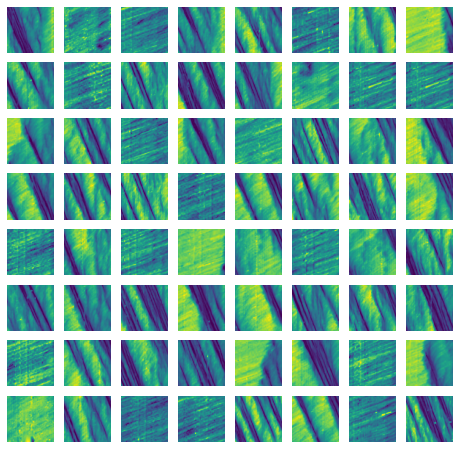

In [11]:
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(data[np.random.randint(data.shape[0])][0].T, origin="lower" )
        ax[i, j].axis("off")

In [12]:
# Normalize the data with min-max scaling

data_min = 0 # data.min()
data_max = data.max()

data = (data - data_min) / (data_max - data_min)

In [13]:
# Split the data into training and validation sets
train_size = int(0.8 * len(data))
val_size = len(data) - train_size

train_data, val_data = torch.utils.data.random_split(data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader = DataLoader(val_data, batch_size=64, shuffle=False)

In [14]:
# Define Variational Autoencoder model

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.enc_conv1 = nn.Conv2d(4, 32, 3, stride=2, padding=1)
        self.enc_conv2 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.enc_conv3 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
        self.enc_fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.enc_fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)

        # Decoder
        self.dec_fc = nn.Linear(latent_dim, 128 * 8 * 8)
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)
        self.dec_conv3 = nn.ConvTranspose2d(32, 4, 3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        x = F.relu(self.enc_conv1(x))
        x = F.relu(self.enc_conv2(x))
        x = F.relu(self.enc_conv3(x))
        x = x.view(x.size(0), -1)
        mu = self.enc_fc_mu(x)
        logvar = self.enc_fc_logvar(x)
        return mu, logvar

    def decode(self, z):
        z = F.relu(self.dec_fc(z))
        z = z.view(z.size(0), 128, 8, 8)
        z = F.relu(self.dec_conv1(z))
        z = F.relu(self.dec_conv2(z))
        z = self.dec_conv3(z)
        return z

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

In [15]:
model = VAE(latent_dim=64)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the loss function
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_loss

In [ ]:
# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(batch)
        loss = vae_loss(recon_batch, batch, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    print(f'Epoch {epoch}, Loss {train_loss / len(train_loader.dataset)}')
    
# Save the model after training
torch.save(model.state_dict(), 'vae_model.pth')
print("Model saved as 'vae_model.pth'")

100%|██████████| 125/125 [00:41<00:00,  3.03it/s]


Epoch 0, Loss 648.777779296875


100%|██████████| 125/125 [00:40<00:00,  3.12it/s]


Epoch 1, Loss 184.68792810058594


100%|██████████| 125/125 [00:42<00:00,  2.91it/s]


Epoch 2, Loss 154.0938966064453


100%|██████████| 125/125 [00:43<00:00,  2.84it/s]


Epoch 3, Loss 139.0818955078125


100%|██████████| 125/125 [00:44<00:00,  2.82it/s]


Epoch 4, Loss 130.91572717285158


100%|██████████| 125/125 [00:43<00:00,  2.87it/s]


Epoch 5, Loss 122.5540372314453


100%|██████████| 125/125 [00:43<00:00,  2.87it/s]


Epoch 6, Loss 116.92483160400391


 55%|█████▌    | 69/125 [00:24<00:18,  2.99it/s]

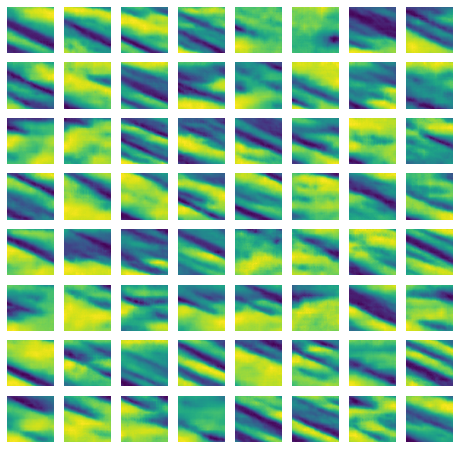

In [7]:
# sample from the latent space
model = VAE(latent_dim=64)
model.load_state_dict(torch.load('vae_model.pth'))
model.eval()

with torch.no_grad():
    z = torch.randn(64, 64)
    sample = model.decode(z).cpu()
    sample = sample.permute(0, 2, 3, 1)

fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(sample[i * 8 + j][:,:,0], origin="lower")
        ax[i, j].axis("off")
plt.show()